# Import Modules

In [1]:
%load_ext autoreload
%autoreload 2

import warnings 
warnings.filterwarnings('ignore')
import logging
import numpy as np
import matplotlib.pyplot as plt

import ray
from ray import tune
from ray import air

import torch
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### Custom package #####
import pytorchGLM as pglm
from pytorchGLM.main.training import *

##### Plotting settings ######
import matplotlib as mpl

mpl.rcParams.update({'font.size':         10,
                     'axes.linewidth':    2,
                     'xtick.major.size':  3,
                     'xtick.major.width': 2,
                     'ytick.major.size':  3,
                     'ytick.major.width': 2,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'font.sans-serif':   "Arial",
                     'font.family':       "sans-serif",
                     'pdf.fonttype':      42,
                     'xtick.labelsize':   10,
                     'ytick.labelsize':   10,
                     'figure.facecolor': 'white'

                    })


# Format Data

## Loading  Niell lab Raw Data

load_aligned_data calls 2 functions when preprocessing the raw data: 
- format_raw_data: formats the raw data based on file_dict and params
- interp_raw_data: interpolates the formamted data from format_raw_data

In [2]:
# Input arguments
args = pglm.arg_parser(jupyter=True)

##### Modify default argments if needed #####
dates_all = ['070921/J553RT' ,'101521/J559NC','102821/J570LT','110421/J569LT'] #,'122021/J581RT','020422/J577RT'] # '102621/J558NC' '062921/G6HCK1ALTRN',
args['date_ani']        = dates_all[0]
args['free_move']       = True
args['train_shifter']   = True
args['Nepochs']         = 10000

ModelID = 1
params, file_dict, exp = pglm.load_params(args,ModelID,file_dict=None,exp_dir_name=None,nKfold=0,debug=False)


In [3]:
data = pglm.load_aligned_data(file_dict, params, reprocess=False)
params = pglm.get_modeltype(params)
train_dataset, test_dataset, network_config = pglm.load_datasets(file_dict,params,single_trial=True)


Tot_units: (128,)
Good_units: (108,)


In [4]:
x,xpos,y = train_dataset[:10]
print(x.shape,xpos.shape,y.shape)

torch.Size([10, 5, 30, 40]) torch.Size([10, 3]) torch.Size([10, 108])


## Custom Dataset Formatting Base Model

This section is dedicated to formatting any custom datasets. The key components are: 
- Formatting data
    - Train/Test Splits
    - Inputs (time,in_features)
    - Optional Inputs (time,pos_features)
    - Outputs (time,Ncells)
- network_config
    - in_features: input dims
    - Ncells: output dims
    - initW: How to initialize weights, 'zero' or 'normal' 
    - optimizer: optmimizer to use: 'adam' or 'sgd'
    - lr_w: learning rate for weights
    - lr_b: learning rate for bias
    - lr_m: learning rate for additional inputs
    - single_trial: flag for single trial or hyperparam seach
    - L1_alpha: L1 regularization parameter. Single value or hyperparam search
    - L1_alpham: L1 regularization parameter. Single value or hyperparam search
    - L2_lambda: L2 regularization parameter. Single value or hyperparam search
    - L2_lambda_m: L2 regularization parameter. Single value or hyperparam search

In [3]:
args = pglm.arg_parser(jupyter=True)
args

{'date_ani': '070921/J553RT',
 'base_dir': '~/Research/SensoryMotorPred_Data/Testing',
 'fig_dir': '~/Research/SensoryMotorPred_Data/FigTesting',
 'data_dir': '~/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/',
 'model_dt': 0.05,
 'ds_vid': 4,
 'Kfold': 0,
 'ModRun': '1',
 'Nepochs': 10,
 'load_ray': False,
 'do_norm': True,
 'crop_input': True,
 'free_move': True,
 'thresh_cells': True,
 'fm_dark': False,
 'NoL1': False,
 'NoL2': False,
 'NoShifter': False,
 'do_shuffle': False,
 'use_spdpup': False,
 'only_spdpup': False,
 'train_shifter': False,
 'shifter_5050': False,
 'shifter_5050_run': False,
 'EyeHead_only': False,
 'EyeHead_only_run': False,
 'SimRF': False}

In [4]:

def load_BaseModel_params(args,exp_dir_name='Testing',ModelID=0,nKfold=0,debug=False):
    """ Load parameter dictionary for custom BaseModel network. Minimal implementation 
        adabpting to custom datasets

    Args:
        args (dict): Argument dictionary 
        exp_dir_name (str): name of experiment. 
        ModelID (int, optional): Model Identification number. Defaults to 0.
        exp_dir_name (str, optional): Optional experiment directory name if using own data. Defaults to None.
        nKfold (int, optional): Kfold number for versioning. Defaults to 0.
        debug (bool, optional): debug=True does not create experiment directories. Defaults to False.

    Returns:
        params (dict): dictionary of parameters
        exp (obj): Test_tube object for organizing files and tensorboard
    """
    import yaml
    from pathlib import Path
    from test_tube import Experiment
    
    ##### Create directories and paths #####
    date_ani2 = '_'.join(args['date_ani'].split('/'))
    data_dir = Path(args['data_dir']).expanduser() / args['date_ani'] / args['stim_cond'] 
    base_dir = Path(args['base_dir']).expanduser()
    save_dir = (base_dir / args['date_ani'] / args['stim_cond'])
    save_dir.mkdir(parents=True, exist_ok=True)
    base_dir.mkdir(parents=True, exist_ok=True)

    ##### Set up test_tube versioning #####
    exp = Experiment(name='ModelID{}'.format(ModelID),
                        save_dir=save_dir / exp_dir_name, 
                        debug=debug,
                        version=nKfold)

    save_model = exp.save_dir / exp.name / 'version_{}'.format(nKfold)

    params = {
        ##### Data Parameters #####
        'data_dir':                 data_dir,
        'base_dir':                 base_dir,
        'exp_name_base':            base_dir.name,
        'stim_cond':                args['stim_cond'],
        'save_dir':                 save_dir,
        'exp_name':                 exp.save_dir.name,
        'save_model':               save_model,
        'date_ani2':                date_ani2,
        'model_dt':                 args['model_dt'],
        ##### Model Parameters #####
        'ModelID':                  ModelID,
        'lag_list':                 [0], # List of which timesteps to include in model fit
        'Nepochs':                  args['Nepochs'],
        'Kfold':                    args['Kfold'],
        'NoL1':                     args['NoL1'],
        'NoL2':                     args['NoL2'],
        'initW':                    'zero',
        'train_shifter':            False,
        'model_type':               'pytorchGLM_custom', # For naming files
    }

    params['nt_glm_lag']=len(params['lag_list']) # number of timesteps for model fits
    params['data_name'] = '_'.join([params['date_ani2'],params['stim_cond']])
    
    ##### Saves yaml of parameters #####
    if debug==False:
        params2=params.copy()
        for key in params2.keys():
            if isinstance(params2[key], Path):
                params2[key]=params2[key].as_posix()

        pfile_path = save_model / 'model_params.yaml'
        with open(pfile_path, 'w') as file:
            doc = yaml.dump(params2, file, sort_keys=True)

    return params, exp


In [5]:
# Input arguments
args = pglm.arg_parser(jupyter=True)

##### Modify default argments if needed #####
args['base_dir']        = '~/Research/SensoryMotorPred_Data/Testing'
args['fig_dir']         = '~/Research/SensoryMotorPred_Data/FigTesting'
args['data_dir']        = '~/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/'
args['date_ani']        = '011523/TestAni'
args['stim_cond']       = 'Control'
args['Nepochs']         = 50
args['NoL1']            = True
args['NoL2']            = False
args['model_dt']        = 0

params, exp = load_BaseModel_params(args=args,exp_dir_name='CustomData',ModelID=0)

In [6]:
from sklearn.gaussian_process.kernels import RBF

seed = 2
np.random.seed(seed)
torch.manual_seed(seed)

def initialize_GP_inputs(Npats,length_scale,batch_size,Nx_low,Nx,Ny_star,Nr,seed=42,multi_input=False,pytorch=True):
    
    ##### Set random seed #####
    np.random.seed(seed+1)
    torch.manual_seed(seed+1)
    ##### Initialize RBF kernels #####
    rbf = RBF(length_scale=length_scale)
    genX = np.arange(Npats)[:,np.newaxis]
    genY = np.arange(Npats)[:,np.newaxis]
    Kx = rbf(genX,genX)
    Ky = rbf(genY,genY)
    if multi_input:
        ##### Initialize inputs #####
        x_low0 = torch.transpose(torch.from_numpy(np.random.multivariate_normal(np.zeros(Npats), Kx,size=(batch_size,Nx_low))),2,1).float()
        x_low1 = torch.transpose(torch.from_numpy(np.random.multivariate_normal(np.zeros(Npats), Kx,size=(batch_size,Nx_low))),2,1).float()
        x_expand = torch.randn(size=(batch_size,Nx_low,Nx)).float()
        x0 = torch.bmm(x_low0,x_expand)
        x1 = torch.bmm(x_low1,x_expand)
        x_all = torch.stack((x0,x1),dim=1).float()
        ##### Initialize target patterns #####
        y_all = torch.transpose(torch.from_numpy(np.random.multivariate_normal(np.zeros(Npats), Ky,size=(1,Ny_star,Nr))),3,2)
        y_all = ((y_all/torch.max(torch.max(torch.abs(y_all),dim=1,keepdim=True)[0],dim=2,keepdim=True)[0]).repeat(batch_size,1,1,1))
    else:
        ##### Initialize inputs #####
        x_low0 = torch.transpose(torch.from_numpy(np.random.multivariate_normal(np.zeros(Npats), Kx,size=(batch_size,Nx_low))),2,1).float()
        x_expand = torch.randn(size=(batch_size,Nx_low,Nx)).float()
        x_all = torch.bmm(x_low0,x_expand)#.numpy()
        # x_all = torch.from_numpy((x_all - np.nanmean(x_all,axis=0))/np.nanstd(x_all,axis=0)).float()
        ##### Initialize target patterns #####
        y_all = torch.from_numpy(np.random.multivariate_normal(np.zeros(Npats), Ky,size=(1,Nr)))
        y_all = torch.transpose((y_all/torch.max(torch.max(torch.abs(y_all),dim=1,keepdim=True)[0],dim=2,keepdim=True)[0]).repeat(batch_size,1,1),-1,-2)

    if pytorch:
        x_all = x_all.float()
        y_all = y_all.float()
    else:
        x_all = x_all.float().numpy()
        y_all = y_all.float().numpy()

    return x_all, y_all


In [7]:
from sklearn.model_selection import GroupShuffleSplit

##### Generating data #####
x_all,y_all = initialize_GP_inputs(Npats=1000,length_scale=5,batch_size=1,Nx_low=2,Nx=100,Ny_star=2,Nr=10,pytorch=True)
x_all, y_all = x_all.squeeze(),y_all.squeeze()
y_all = (y_all+1)/2
x_all = (x_all - np.nanmean(x_all,axis=0))/np.nanstd(x_all,axis=0)

##### Train/Test Splits ####
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)
frac = 0.1
nT = x_all.shape[0]
groups = np.hstack([i*np.ones(int((frac*i)*nT) - int((frac*(i-1))*nT)) for i in range(1,int(1/frac)+1)])
train_idx, test_idx = next(iter(gss.split(np.arange(x_all.shape[0]), groups=groups)))
# train_idx, test_idx = torch.from_numpy(train_idx), torch.from_numpy(test_idx)
xtr,xte = x_all[train_idx], x_all[test_idx]
xtr_pos,xte_pos = torch.zeros_like(xtr).float(),torch.zeros_like(xte).float()
ytr,yte = y_all[train_idx], y_all[test_idx]

print('X:',xtr.shape,'Xpos:',xtr_pos.shape,'y:',ytr.shape)
print('X:',xte.shape,'Xpos:',xte_pos.shape,'y:',yte.shape)
params['nk'] = xtr.shape[-1]
params['Ncells'] = ytr.shape[-1]
train_dataset = pglm.FreeMovingEphysDataset(xtr,xtr_pos,ytr)
test_dataset = pglm.FreeMovingEphysDataset(xte,xte_pos,yte)
meanbias = torch.mean(y_all,dim=0)


X: torch.Size([800, 100]) Xpos: torch.Size([800, 100]) y: torch.Size([800, 10])
X: torch.Size([200, 100]) Xpos: torch.Size([200, 100]) y: torch.Size([200, 10])


In [8]:
params['initW'] = 'normal' #'zero' # 'normal'
params['optimizer'] = 'sgd'
network_config = pglm.make_network_config(params,single_trial=0,custom=True)
network_config['lr_w'] = .001
network_config['lr_b'] = .1

In [9]:
tloss_trace,vloss_trace,model,optimizer = train_network(network_config, params=params,train_dataset=train_dataset,test_dataset=test_dataset,filename=None,meanbias=meanbias)

  0%|          | 0/100 [00:00<?, ?it/s]

In [10]:
##### Make prediction #####
yhat = model(xte.to(device),xte_pos.to(device)).detach().cpu().numpy().squeeze()
yt = yte.cpu().detach().numpy().squeeze()

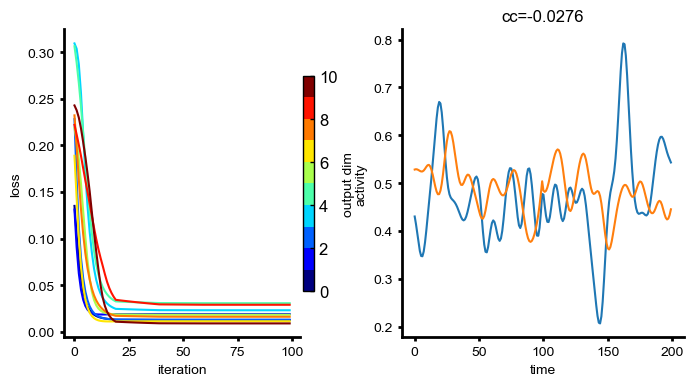

In [18]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
ax = axs[0]
cmap = pglm.discrete_cmap(vloss_trace.shape[-1],'jet')
for cell in range(vloss_trace.shape[-1]):
    ax.plot(vloss_trace[:,cell],c=cmap(cell))
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=vloss_trace.shape[-1]))
cbar = fig.colorbar(sm,ax=ax,format=None,shrink=0.7,pad=0.01)
cbar.outline.set_linewidth(1)
cbar.set_label('output dim')
cbar.ax.tick_params(labelsize=12, width=1,direction='in')

ncell = 0
ax = axs[1]
ax.plot(yte[:,ncell])
ax.plot(yhat[:,ncell])
ax.set_xlabel('time')
ax.set_ylabel('activity')
ax.set_title('cc={:.03}'.format(np.corrcoef(yhat[:,ncell],yte[:,ncell])[1,0]))
plt.show()

In [12]:
from sklearn.linear_model import LinearRegression
x_all2,y_all2 = initialize_GP_inputs(Npats=1000,length_scale=5,batch_size=1,Nx_low=2,Nx=100,Ny_star=2,Nr=50,pytorch=False)
x_all2, y_all2 = x_all2.squeeze(),y_all2.squeeze()
y_all2 = (y_all2+1)/2
x_all2 = x_all2/np.max(np.abs(x_all2))
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)
frac = 0.1
nT = x_all2.shape[0]
groups = np.hstack([i*np.ones(int((frac*i)*nT) - int((frac*(i-1))*nT)) for i in range(1,int(1/frac)+1)])
train_idx, test_idx = next(iter(gss.split(np.arange(x_all2.shape[0]), groups=groups)))
# train_idx, test_idx = torch.from_numpy(train_idx), torch.from_numpy(test_idx)
xtr2,xte2 = x_all2[train_idx], x_all2[test_idx]
xtr_pos2,xte_pos2 = np.zeros_like(xtr2),np.zeros_like(xte2)
ytr2,yte2 = y_all2[train_idx], y_all2[test_idx]


l1 = LinearRegression()
l1.fit(xtr2,ytr2)
yhat2 = l1.predict(xte2)
print('cc=',np.corrcoef(yhat2[:,ncell],yte2[:,ncell])[0,1])

cc= -0.015062461290473502


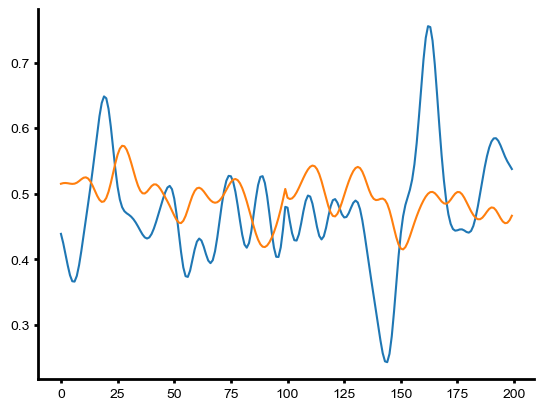

In [13]:
plt.plot(yte2[:,ncell])
plt.plot(yhat2[:,ncell])

# Ray Tune Training: Parallel Cross Validation

In [2]:
import ray
from ray import tune
from ray.air import session
from ray.tune.search import ConcurrencyLimiter
from ray.tune.search.hyperopt import HyperOptSearch
from hyperopt import hp
from tqdm.auto import tqdm

In [3]:
# Input arguments
args = pglm.arg_parser(jupyter=True)
device = torch.device("cuda:{}".format(pglm.get_freer_gpu()) if torch.cuda.is_available() else "cpu")
print('Device:',device)
# ModRun = [int(i) for i in args['ModRun'].split(',')] #[0,1,2,3,4] #-1,
ModRun = [-1]
Kfold = args['Kfold']

for ModelRun in ModRun:
    if ModelRun == -1: # train shifter
        Nepochs_saved = args['Nepochs']
        args['train_shifter']  = True
        args['Nepochs']        = 5000
        ModelID                = 1
        params, file_dict, exp = pglm.load_params(args,ModelID,exp_dir_name=None,nKfold=0,debug=False)
        params['lag_list']     = [0]
        params['nt_glm_lag']   = len(params['lag_list'])
    elif ModelRun == 0: # pos only
        args['train_shifter']  = False
        ModelID                = 0
        params, file_dict, exp = pglm.load_params(args,ModelID,exp_dir_name=None,nKfold=0,debug=False)
    elif ModelRun == 1: # vis only
        args['train_shifter']  = False
        ModelID                = 1
        params, file_dict, exp = pglm.load_params(args,ModelID,exp_dir_name=None,nKfold=0,debug=False)
    elif ModelRun == 2: # add fit
        args['train_shifter']  = False
        # args['NoL1']           = False
        ModelID                = 2
        params, file_dict, exp = pglm.load_params(args,ModelID,exp_dir_name=None,nKfold=0,debug=False)
        ##### Grab Best Vis Network Name #####
        exp_filename = list((params['save_model_Vis'] / ('NetworkAnalysis/')).glob('*experiment_data.h5'))[-1]
        _,metadata= pglm.h5load(exp_filename)
        params['best_vis_network'] = params['save_model_Vis']/metadata['best_network'].name
    elif ModelRun == 3: # mul. fit
        args['train_shifter']  = False
        # args['NoL1']           = False
        ModelID                = 3
        params, file_dict, exp = pglm.load_params(args,ModelID,exp_dir_name=None,nKfold=0,debug=False)
        ##### Grab Best Vis Network Name #####
        exp_filename = list((params['save_model_Vis'] / ('NetworkAnalysis/')).glob('*experiment_data.h5'))[-1]
        _,metadata= pglm.h5load(exp_filename)
        params['best_vis_network'] = params['save_model_Vis']/metadata['best_network'].name
    elif ModelRun == 4: # head-fixed
        args['train_shifter']  = False
        args['free_move']      = False
        # args['NoL1']           = False
        ModelID                = 4
        params, file_dict, exp = pglm.load_params(args,ModelID,exp_dir_name=None,nKfold=0,debug=False)


    data = pglm.load_aligned_data(file_dict, params, reprocess=False)
    params = pglm.get_modeltype(params)
    datasets, network_config, initial_params = pglm.load_datasets(file_dict,params)

    algo = HyperOptSearch(points_to_evaluate=initial_params)
    algo = ConcurrencyLimiter(algo, max_concurrent=4)
    num_samples = args['num_samples']

    sync_config = tune.SyncConfig()  # the default mode is to use use rsync
    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_network,**datasets,params=params),
            resources={"cpu": 4, "gpu": .25}),
        tune_config=tune.TuneConfig(metric="avg_loss",mode="min",search_alg=algo,num_samples=num_samples),
        param_space=network_config,
        run_config=air.RunConfig(local_dir=params['save_model'], name="NetworkAnalysis",sync_config=sync_config,verbose=2)
    )
    results = tuner.fit()

    best_result = results.get_best_result("avg_loss", "min")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(best_result.metrics["avg_loss"]))
    df = results.get_dataframe()
    best_network = list(params['save_model'].rglob('*{}.pt'.format(best_result.metrics['trial_id'])))[0]
    exp_filename = '_'.join([params['model_type'],params['data_name']]) + '_experiment_data.h5'
    pglm.h5store(params['save_model'] / ('NetworkAnalysis/{}'.format(exp_filename)), df, **{'best_network':best_network,'trial_id':best_result.metrics['trial_id']})

    evaluate_networks(best_network,network_config,params,datasets['xte'],datasets['xte_pos'],datasets['yte'])

    

Device: cuda:0
Tot_units: (128,)
Good_units: (108,)


2023-01-16 13:24:09,009	INFO worker.py:1538 -- Started a local Ray instance.


2023-01-16 13:24:22,071	ERROR trial_runner.py:1088 -- Trial train_network_abc9b343: Error processing event.
ray.exceptions.RayTaskError(TypeError): ray::ImplicitFunc.train() (pid=2853692, ip=184.171.84.86, repr=train_network)
  File "/home/seuss/anaconda3/envs/pytorchGLM/lib/python3.8/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/home/seuss/anaconda3/envs/pytorchGLM/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/home/seuss/anaconda3/envs/pytorchGLM/lib/python3.8/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/home/seuss/anaconda3/envs/pytorchGLM/lib/python3.8/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, checkpoint_dir=None)
  File "/home/seuss/anaconda3/envs/pytorchGLM/lib/python3.8/site-packages/ray/tune/trainable

(train_network pid=2853692) /home/seuss/Research/SensoryMotorPred_Data/Testing/070921/J553RT/fm1/CropInputs/ModelID2/version_0/NetworkAnalysis/train_network_abc9b343_1_L1_alpha=None,L1_alpha_m=None,L2_lambda=0,L2_lambda_m=0.0100,LinMix=True,Ncells=108,in_features=3000,init_2023-01-16_13-24-11/


Trial name
train_network_abc9b343


2023-01-16 13:24:25,976	WARNING tune.py:690 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 


(train_network pid=2853922) /home/seuss/Research/SensoryMotorPred_Data/Testing/070921/J553RT/fm1/CropInputs/ModelID2/version_0/NetworkAnalysis/train_network_d0774b91_3_L1_alpha=None,L1_alpha_m=None,L2_lambda=0,L2_lambda_m=3.9668,LinMix=True,Ncells=108,in_features=3000,init_2023-01-16_13-24-15/
(train_network pid=2853916) /home/seuss/Research/SensoryMotorPred_Data/Testing/070921/J553RT/fm1/CropInputs/ModelID2/version_0/NetworkAnalysis/train_network_4a127013_2_L1_alpha=None,L1_alpha_m=None,L2_lambda=0,L2_lambda_m=0.1471,LinMix=True,Ncells=108,in_features=3000,init_2023-01-16_13-24-15/
(train_network pid=2853924) /home/seuss/Research/SensoryMotorPred_Data/Testing/070921/J553RT/fm1/CropInputs/ModelID2/version_0/NetworkAnalysis/train_network_1eb3ce99_4_L1_alpha=None,L1_alpha_m=None,L2_lambda=0,L2_lambda_m=181.3753,LinMix=True,Ncells=108,in_features=3000,in_2023-01-16_13-24-15/


In [26]:

from ray.air.checkpoint import Checkpoint
checkpoint = Checkpoint.from_directory(params['save_model'])

In [1]:
best_result.

NameError: name 'best_result' is not defined

In [17]:
model = pglm.model_wrapper((network_config,pglm.MixedNetwork))
exp_filename = list((params['save_model_Vis'] / ('NetworkAnalysis/')).glob('*experiment_data.h5'))[-1]
_,metadata= pglm.h5load(exp_filename)
# best_network2 = params['save_model_Vis']/metadata['best_network'].name
model = pglm.load_model(model,params,filename=params['best_vis_network'])


In [ ]:
xtr,xtr_pos,ytr = datasets['xtr'],datasets['xtr_pos'],datasets['ytr']
outputs = model(xtr,xtr_pos)
loss = model.loss(outputs, ytr)

In [5]:
# initial_params = [
#     {"lr_w": 0.001,"lr_b": 0.1, 'L2_lambda':.01},
# ]
algo = HyperOptSearch(points_to_evaluate=initial_params)
algo = ConcurrencyLimiter(algo, max_concurrent=4)
num_samples = 20

In [ ]:

sync_config = tune.SyncConfig()  # the default mode is to use use rsync
tuner = tune.Tuner(
    tune.with_resources(
        tune.with_parameters(train_network,**datasets,params=params),
        resources={"cpu": 4, "gpu": .25}),
    tune_config=tune.TuneConfig(metric="avg_loss",mode="min",search_alg=algo,num_samples=num_samples),
    param_space=network_config,
    run_config=air.RunConfig(local_dir=params['save_model'], name="NetworkAnalysis",sync_config=sync_config,verbose=2)
)
results = tuner.fit()

best_result = results.get_best_result("avg_loss", "min")

print("Best trial config: {}".format(best_result.config))
print("Best trial final validation loss: {}".format(best_result.metrics["avg_loss"]))
df = results.get_dataframe()
best_network = list(params['save_model'].glob('*{}.pt'.format(best_result.metrics['trial_id'])))[0]
exp_filename = '_'.join([params['model_type'],params['data_name']]) + '_experiment_data.h5'
pglm.h5store(params['save_model'] / ('NetworkAnalysis/{}'.format(exp_filename)), df, **{'best_network':best_network,'trial_id':best_result.metrics['trial_id']})



In [8]:
state_dict,_ =torch.load(best_network,map_location='cpu')

In [12]:
model = pglm.model_wrapper((network_config,pglm.MixedNetwork))
model.load_state_dict(state_dict)
model.to(device)

MixedNetwork(
  (Cell_NN): Sequential(
    (0): Linear(in_features=3000, out_features=108, bias=True)
  )
  (activations): ModuleDict(
    (SoftPlus): Softplus(beta=1, threshold=20)
    (ReLU): ReLU()
  )
  (posNN): Sequential(
    (0): Linear(in_features=4, out_features=108, bias=True)
  )
)

In [13]:
xtr, xte, xtr_pos, xte_pos, ytr, yte = datasets['xtr'], datasets['xte'], datasets['xtr_pos'], datasets['xte_pos'], datasets['ytr'], datasets['yte']
xtr, xte, xtr_pos, xte_pos, ytr, yte =xtr.to(device), xte.to(device), xtr_pos.to(device), xte_pos.to(device), ytr.to(device), yte.to(device)


In [16]:
with torch.no_grad():
    yhat = model(xte,xte_pos)

In [24]:
actual_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=yte.cpu().numpy())[params['bin_length']:-params['bin_length']]

pred_smooth = np.apply_along_axis(lambda m: np.convolve(m, np.ones(params['bin_length']), mode='same')/(params['bin_length'] * params['model_dt']), axis=0, arr=yhat.cpu().numpy())[params['bin_length']:-params['bin_length']]
cc_test = np.array([(np.corrcoef(pred_smooth[:,celln],actual_smooth[:,celln])[0, 1]) for celln in range(pred_smooth.shape[1])])

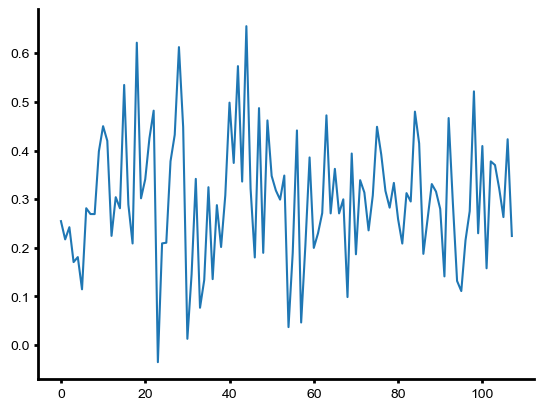

In [18]:
actual_smooth.shape,pred_smooth.shape

((13060, 108), (28, 13140))

In [6]:
RFs = state_dict['Cell_NN.0.weight'].reshape((params['Ncells'],params['nt_glm_lag'])+params['nks']).numpy()
# RFs = model.Cell_NN[0].weight.reshape((params['Ncells'],params['nt_glm_lag'])+params['nks']).cpu().detach().numpy()

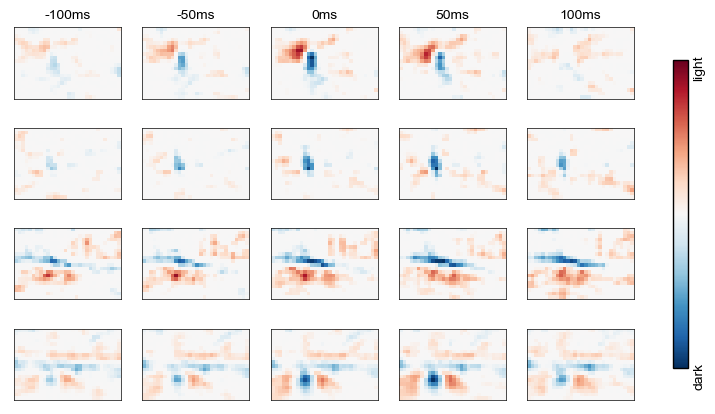

In [7]:
cells = [22,34,42,101] #np.arange(18)
lag_list = [0,1,2,3,4]
lag_ls = [-100,-50,0,50,100]
fig, axs = plt.subplots(4,5,figsize=(10,5))
for n, cell in enumerate(cells):
    crange = np.max(np.abs(RFs[cell]))
    for m,lag in enumerate(lag_list):
        ax = axs[n,m]
        im = ax.imshow(RFs[cell,lag],'RdBu_r',vmin=-crange,vmax=crange)
        axs[0,m].set_title('{}ms'.format(lag_ls[m]),fontsize=10)


cbar2 = fig.colorbar(im, ax=axs,shrink=.8)
cbar2.set_ticks([-crange, crange])
cbar2.set_ticklabels(['dark', 'light'])
cbar2.ax.tick_params(labelsize=10, rotation=90,width=0,length=0)
cbar2.outline.set_linewidth(1)

for ax in axs.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

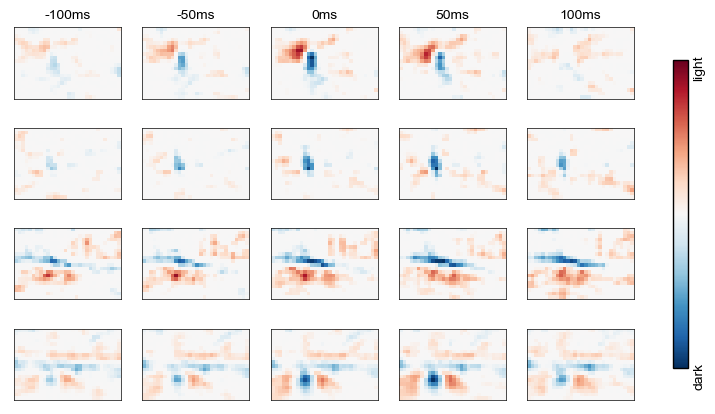

In [ ]:
cells = [22,34,42,101] #np.arange(18)
lag_list = [0,1,2,3,4]
lag_ls = [-100,-50,0,50,100]
fig, axs = plt.subplots(4,5,figsize=(10,5))
for n, cell in enumerate(cells):
    crange = np.max(np.abs(RFs[cell]))
    for m,lag in enumerate(lag_list):
        ax = axs[n,m]
        im = ax.imshow(RFs[cell,lag],'RdBu_r',vmin=-crange,vmax=crange)
        axs[0,m].set_title('{}ms'.format(lag_ls[m]),fontsize=10)


cbar2 = fig.colorbar(im, ax=axs,shrink=.8)
cbar2.set_ticks([-crange, crange])
cbar2.set_ticklabels(['dark', 'light'])
cbar2.ax.tick_params(labelsize=10, rotation=90,width=0,length=0)
cbar2.outline.set_linewidth(1)

for ax in axs.flat:
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
        ax.spines[axis].set_visible(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

# Loading Shifter

In [7]:
exp_filename = list((params['save_model_shift'] / ('NetworkAnalysis/')).glob('*_experiment_data.h5'))[-1]
df,metadata= pglm.h5load(exp_filename)

best_network = params['save_model']/metadata['best_network'].name
# best_network = metadata['best_network'].name

state_dict,optim2=torch.load(best_network,map_location='cpu')


In [ ]:

RF = state_dict['Cell_NN.0.weight'].reshape((params['Ncells'],)+params['nks'])

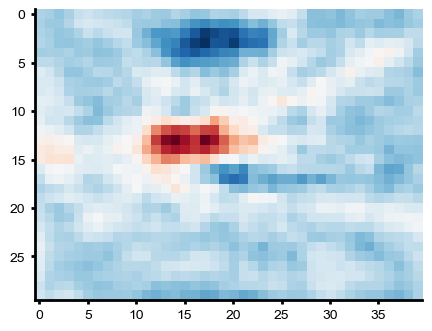

In [13]:
fig,axs = plt.subplots(figsize=(5,5))
ax = axs
ax.imshow(RF[10],cmap='RdBu_r')

In [97]:
df[df['trial_id']==best_network.name.split('_')[-1][:-3]]['config/L2_lambda']

10    13.296011
Name: config/L2_lambda, dtype: float64

In [6]:
from matplotlib.backends.backend_pdf import PdfPages

##### Save Shifted World Camera Video if Training Shifter #####
exp_filename = '_'.join([params['model_type'],params['data_name']]) + 'experiment_data.h5'
df,metadata= pglm.h5load(params['save_model'] / ('NetworkAnalysis/{}'.format(exp_filename)))
best_network = params['save_model_shift']/metadata['best_network'].name

state_dict,optim2=torch.load(best_network,map_location='cpu')
model = pglm.model_wrapper((network_config,pglm.ShifterNetwork))
model.load_state_dict(state_dict)
model.cpu()


ShifterNetwork(
  (Cell_NN): Sequential(
    (0): Linear(in_features=1200, out_features=108, bias=True)
  )
  (activations): ModuleDict(
    (SoftPlus): Softplus(beta=1, threshold=20)
    (ReLU): ReLU()
  )
  (shifter_nn): Sequential(
    (0): Linear(in_features=3, out_features=20, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=20, out_features=3, bias=True)
  )
)

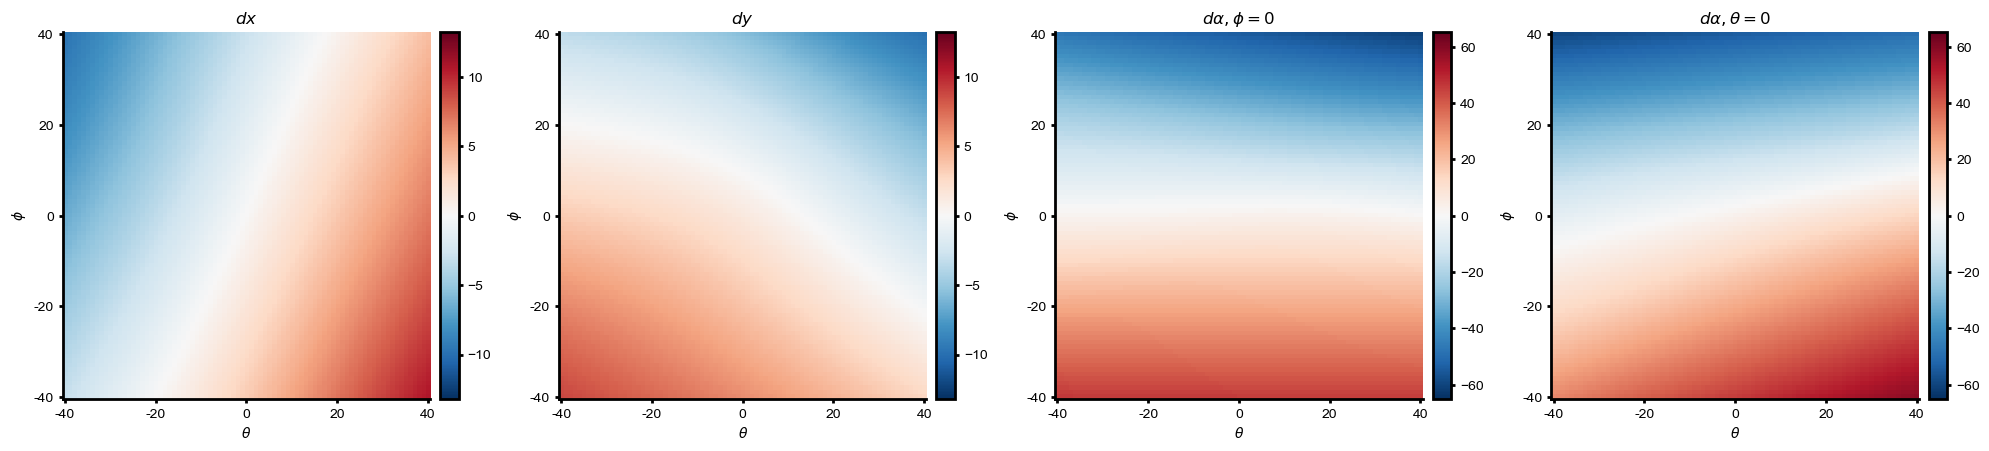

In [7]:

##### Sweep -40 to 40 degrees
FM_move_avg = np.load(params['save_dir_fm']/'FM_MovAvg_{}_dt{:03d}.npy'.format(params['data_name'],int(params['model_dt']*1000)))
th_range = 40/FM_move_avg[1,0]
phi_range = 40/FM_move_avg[1,1]
pitch_range = 40/FM_move_avg[1,2]
n_ranges = 81
ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.linspace(-th_range,th_range,n_ranges),np.linspace(-phi_range,phi_range,n_ranges),np.linspace(-pitch_range,pitch_range,n_ranges),sparse=False,indexing='ij')
shift_mat = np.zeros((3,) + ang_sweepx.shape)
for i in range(ang_sweepx.shape[0]):
    for j in range(ang_sweepy.shape[1]):
        ang_sweep = torch.from_numpy(np.vstack((ang_sweepx[i,j,:],ang_sweepy[i,j,:],ang_sweepz[i,j,:])).astype(np.float32).T)
        shift_vec = model.shifter_nn(ang_sweep).detach().cpu().numpy()
        shift_mat[0,i,j] = shift_vec[:,0]
        shift_mat[1,i,j] = shift_vec[:,1]
        shift_mat[2,i,j] = shift_vec[:,2]

    
fig, ax = plt.subplots(1,4,figsize=(20,5))
shift_titles = [r'$dx$',r'$dy$',r'$d\alpha,\phi=0$',r'$d\alpha,\theta=0$']
ticks=np.arange(0,90,20)
ticklabels=np.arange(-40,50,20)
shift_matshow=np.stack((shift_mat[0,:,:,40].T,shift_mat[1,:,:,40].T,shift_mat[2,:,40,:].T,shift_mat[2,40,:,:].T))
crange_list = np.stack((np.max(np.abs(shift_mat[:2])),np.max(np.abs(shift_mat[:2])), np.max(np.abs(shift_mat[2])), np.max(np.abs(shift_mat[2]))))
for n in range(4):
    im1=ax[n].imshow(shift_matshow[n],vmin=-crange_list[n], vmax=crange_list[n], origin='lower', cmap='RdBu_r')
    cbar1 = pglm.add_colorbar(im1)
    ax[n].set_xticks(ticks)
    ax[n].set_xticklabels(ticklabels)
    ax[n].set_yticks(ticks)
    ax[n].set_yticklabels(ticklabels)
    ax[n].set_xlabel(r'$\theta$')
    ax[n].set_ylabel(r'$\phi$')
    ax[n].set_title(shift_titles[n])
# plt.suptitle('Lambda={}, Best_shifter={}'.format(l,best_shifter),y=1)

plt.tight_layout()



In [90]:


def evaluate_shifter(args,params):
    from kornia.geometry.transform import Affine
    import pytorchGLM.Utils.io_dict_to_hdf5 as ioh5
    from matplotlib.backends.backend_pdf import PdfPages

    Nepochs_saved = params['Nepochs']
    ##### Save Shifted World Camera Video if Training Shifter #####
    params, file_dict, exp = pglm.load_params(args,ModelID,exp_dir_name=None,nKfold=0,debug=False)
    params = pglm.get_modeltype(params)
    exp_filename = '_'.join([params['model_type'],date_name_fm]) + '_experiment_data.h5'
    df,metadata= pglm.h5load(params['save_model_shift'] / ('NetworkAnalysis/{}'.format(exp_filename)))
    best_network = params['save_model_shift']/metadata['best_network'].name

    state_dict,optim2=torch.load(best_network,map_location='cpu')
    model = pglm.model_wrapper((network_config,pglm.ShifterNetwork))
    model.load_state_dict(state_dict)
    model.cpu()
    pdf_name = params['save_model_shift']/ 'VisMov_{}_dt{:03d}_Lags{:02d}_MovModel{:d}_CellSummary.pdf'.format(params['model_type'],int(params['model_dt']*1000),params['nt_glm_lag'], params['ModelID'])
    with PdfPages(pdf_name) as pdf:
        ##### Sweep -40 to 40 degrees
        FM_move_avg = np.load(params['save_dir_fm']/'FM_MovAvg_{}_dt{:03d}.npy'.format(params['data_name_fm'],int(params['model_dt']*1000)))
        th_range = 40/FM_move_avg[1,0]
        phi_range = 40/FM_move_avg[1,1]
        pitch_range = 40/FM_move_avg[1,2]
        n_ranges = 81
        ang_sweepx,ang_sweepy,ang_sweepz = np.meshgrid(np.linspace(-th_range,th_range,n_ranges),np.linspace(-phi_range,phi_range,n_ranges),np.linspace(-pitch_range,pitch_range,n_ranges),sparse=False,indexing='ij')
        shift_mat = np.zeros((3,) + ang_sweepx.shape)
        for i in range(ang_sweepx.shape[0]):
            for j in range(ang_sweepy.shape[1]):
                ang_sweep = torch.from_numpy(np.vstack((ang_sweepx[i,j,:],ang_sweepy[i,j,:],ang_sweepz[i,j,:])).astype(np.float32).T)
                shift_vec = model.shifter_nn(ang_sweep).detach().cpu().numpy()
                shift_mat[0,i,j] = shift_vec[:,0]
                shift_mat[1,i,j] = shift_vec[:,1]
                shift_mat[2,i,j] = shift_vec[:,2]

            
        fig, ax = plt.subplots(1,4,figsize=(20,5))
        shift_titles = [r'$dx$',r'$dy$',r'$d\alpha,\phi=0$',r'$d\alpha,\theta=0$']
        ticks=np.arange(0,90,20)
        ticklabels=np.arange(-40,50,20)
        shift_matshow=np.stack((shift_mat[0,:,:,40].T,shift_mat[1,:,:,40].T,shift_mat[2,:,40,:].T,shift_mat[2,40,:,:].T))
        crange_list = np.stack((np.max(np.abs(shift_mat[:2])),np.max(np.abs(shift_mat[:2])), np.max(np.abs(shift_mat[2])), np.max(np.abs(shift_mat[2]))))
        for n in range(4):
            im1=ax[n].imshow(shift_matshow[n],vmin=-crange_list[n], vmax=crange_list[n], origin='lower', cmap='RdBu_r')
            cbar1 = pglm.add_colorbar(im1)
            ax[n].set_xticks(ticks)
            ax[n].set_xticklabels(ticklabels)
            ax[n].set_yticks(ticks)
            ax[n].set_yticklabels(ticklabels)
            ax[n].set_xlabel(r'$\theta$')
            ax[n].set_ylabel(r'$\phi$')
            ax[n].set_title(shift_titles[n])
        # plt.suptitle('Lambda={}, Best_shifter={}'.format(l,best_shifter),y=1)
        plt.tight_layout()
        pdf.savefig()
        plt.close()

    ##### Save FM Shifted World Cam #####
    data = pglm.load_aligned_data(file_dict, params, reprocess=False)
    data,train_idx_list,test_idx_list = pglm.format_data(data, params,do_norm=True,thresh_cells=True,cut_inactive=True)
    model_pos = np.hstack((data['model_th'][:, np.newaxis], data['model_phi'][:, np.newaxis],data['model_pitch'][:, np.newaxis]))
    ds=4/params['downsamp_vid']
    with torch.no_grad():
        shift_out = model.shifter_nn(torch.from_numpy(model_pos.astype(np.float32)))
        shift = Affine(torch.clamp(shift_out[:,-1],min=-45,max=45),translation=torch.clamp(shift_out[:,:2]*ds,min=-20*ds,max=20*ds))
        model_vid_sm_shift = shift(torch.from_numpy(data['model_vid_sm'][:,np.newaxis].astype(np.float32))).detach().cpu().numpy().squeeze()
    model_file = params['save_dir'] / 'ModelData_{}_dt{:03d}_rawWorldCam_{:d}ds.h5'.format(params['data_name_fm'],int(params['model_dt']*1000),int(params['downsamp_vid']))
    model_data = ioh5.load(model_file)
    model_data['model_vid_sm_shift'] = model_vid_sm_shift
    ioh5.save(model_file,model_data)
    print('saved FM shifted video')

    ##### Save HF Shifted World Cam #####
    args['free_move'] = False
    args['train_shifter']=True
    args['Nepochs'] = 5000
    params, file_dict, exp = pglm.load_params(args,ModelID,exp_dir_name=None,nKfold=0,debug=False)
    params['lag_list'] = [0]
    params['nt_glm_lag']=len(params['lag_list'])
    data = pglm.load_aligned_data(file_dict, params, reprocess=False)
    data,train_idx_list,test_idx_list = pglm.format_data(data, params,do_norm=True,thresh_cells=True,cut_inactive=True)
    model_pos = np.hstack((data['model_th'][:, np.newaxis], data['model_phi'][:, np.newaxis],data['model_pitch'][:, np.newaxis]))
    ds=4/params['downsamp_vid']
    with torch.no_grad():
        shift_out = model.shifter_nn(torch.from_numpy(model_pos.astype(np.float32)))
        shift = Affine(torch.clamp(shift_out[:,-1],min=-45,max=45),translation=torch.clamp(shift_out[:,:2]*ds,min=-20*ds,max=20*ds))
        model_vid_sm_shift = shift(torch.from_numpy(data['model_vid_sm'][:,np.newaxis].astype(np.float32))).detach().cpu().numpy().squeeze()
    model_file = params['save_dir'] / 'ModelData_{}_dt{:03d}_rawWorldCam_{:d}ds.h5'.format(params['data_name'],int(params['model_dt']*1000),int(params['downsamp_vid']))
    model_data = ioh5.load(model_file)
    model_data['model_vid_sm_shift'] = model_vid_sm_shift
    ioh5.save(model_file,model_data)
    print('saved HF shifted video')
    args['free_move'] = True
    args['Nepochs'] = Nepochs_saved
    

In [91]:
evaluate_shifter(args,params)

Tot_units: (128,)
Good_units: (108,)
saved FM shifted video
Tot_units: (128,)
Good_units: (108,)
saved HF shifted video


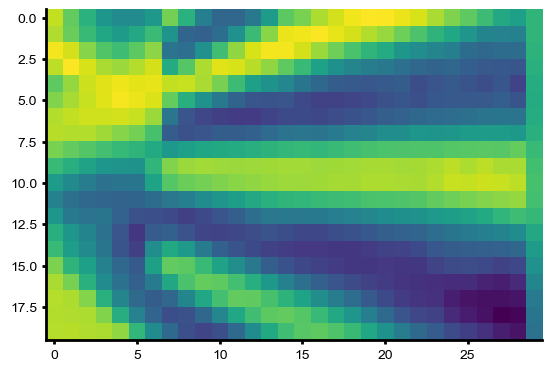

In [48]:
plt.imshow(model_vid_sm_shift[100,params['crop_input']:-params['crop_input'],params['crop_input']:-params['crop_input']])

In [12]:
args['free_move'] = False
args['train_shifter']=True
args['Nepochs'] = 5000
params, file_dict, exp = pglm.load_params(args,ModelID,exp_dir_name=None,nKfold=0,debug=False)
params['lag_list'] = [0]
params['nt_glm_lag']=len(params['lag_list'])
raw_data, goodcells = pglm.format_raw_data(file_dict,params)

opening worldcam data
opening speed data
opening ephys data
getting good cells
opening eyecam data
adjusting camera times to match ephys
(50029, 120, 160)
correcting ephys spike times for offset and timing drift


In [24]:
('acc' in raw_data.keys()) & (np.size(raw_data['acc']['gz'])>0)

False

In [25]:
##### Save HF Shifted World Cam #####
args['free_move'] = False
args['train_shifter']=True
args['Nepochs'] = 5000
params, file_dict, exp = pglm.load_params(args,ModelID,exp_dir_name=None,nKfold=0,debug=False)
params['lag_list'] = [0]
params['nt_glm_lag']=len(params['lag_list'])
data = pglm.load_aligned_data(file_dict, params, reprocess=False)


opening worldcam data
opening speed data
opening ephys data
getting good cells
opening eyecam data
adjusting camera times to match ephys
(50029, 120, 160)
correcting ephys spike times for offset and timing drift


  0%|          | 0/18773 [00:00<?, ?it/s]

In [53]:
params['save_dir_fm_exp']

PosixPath('/home/seuss/Research/SensoryMotorPred_Data/Testing/070921/J553RT/fm1/CropInputs')

In [64]:
import pandas as pd
store = pd.HDFStore('/home/seuss/Research/SensoryMotorPred_Data/Testing/070921/J553RT/fm1/CropInputs/Shifter/NetworkAnalysis/experiment_data.h5')

In [67]:
exp_filename

'Pytorch_VisShifter_NoL1_070921_J553RT_hf1_wnexperiment_data.h5'

In [68]:
params, file_dict, exp = pglm.load_params(args,ModelID,exp_dir_name=None,nKfold=0,debug=False)
params = pglm.get_modeltype(params)
exp_filename = '_'.join([params['model_type'],'_'.join(params['data_name'].split('_')[:-2] + [params['fm_dir']])]) + '_experiment_data.h5'
df,metadata= pglm.h5load(params['save_model_shift'] / ('NetworkAnalysis/{}'.format(exp_filename)))

In [40]:
data = pglm.load_aligned_data(file_dict, params, reprocess=False)

data,train_idx_list,test_idx_list = pglm.format_data(data, params,do_norm=True,thresh_cells=True,cut_inactive=True)


Tot_units: (128,)
Good_units: (108,)


In [71]:
from kornia.geometry.transform import Affine
import pytorchGLM.Utils.io_dict_to_hdf5 as ioh5

In [81]:
params = pglm.get_modeltype(params)
exp_filename = '_'.join([params['model_type'],'_'.join(params['data_name'].split('_')[:-2] + [params['fm_dir']])]) + '_experiment_data.h5'
df,metadata= pglm.h5load(params['save_model_shift'] / ('NetworkAnalysis/{}'.format(exp_filename)))
best_network = params['save_model_shift']/metadata['best_network'].name

state_dict,optim2=torch.load(best_network,map_location='cpu')
model = pglm.model_wrapper((network_config,pglm.ShifterNetwork))
model.load_state_dict(state_dict)
model.cpu()
##### Save HF Shifted World Cam #####
args['free_move'] = False
args['train_shifter']=True
args['Nepochs'] = 5000
params, file_dict, exp = pglm.load_params(args,ModelID,exp_dir_name=None,nKfold=0,debug=False)
params['lag_list'] = [0]
params['nt_glm_lag']=len(params['lag_list'])
data = pglm.load_aligned_data(file_dict, params, reprocess=False)
data,train_idx_list,test_idx_list = pglm.format_data(data, params,do_norm=True,thresh_cells=True,cut_inactive=True)
model_pos = np.hstack((data['model_th'][:, np.newaxis], data['model_phi'][:, np.newaxis],data['model_pitch'][:, np.newaxis]))
ds=4/params['downsamp_vid']
with torch.no_grad():
    shift_out = model.shifter_nn(torch.from_numpy(model_pos.astype(np.float32)))
    shift = Affine(torch.clamp(shift_out[:,-1],min=-45,max=45),translation=torch.clamp(shift_out[:,:2]*ds,min=-20*ds,max=20*ds))
    model_vid_sm_shift = shift(torch.from_numpy(data['model_vid_sm'][:,np.newaxis].astype(np.float32))).detach().cpu().numpy().squeeze()
model_file = params['save_dir'] / 'ModelData_{}_dt{:03d}_rawWorldCam_{:d}ds.h5'.format(params['data_name'],int(params['model_dt']*1000),int(params['downsamp_vid']))
model_data = ioh5.load(model_file)
model_data['model_vid_sm_shift'] = model_vid_sm_shift
ioh5.save(model_file,model_data)
args['free_move'] = True
args['Nepochs'] = Nepochs_saved

Tot_units: (128,)
Good_units: (108,)


In [78]:
model_data = ioh5.load(model_file)
model_data.keys()

dict_keys(['model_eyerad', 'model_nsp', 'model_phi', 'model_t', 'model_th', 'model_vid_sm', 'unit_nums'])

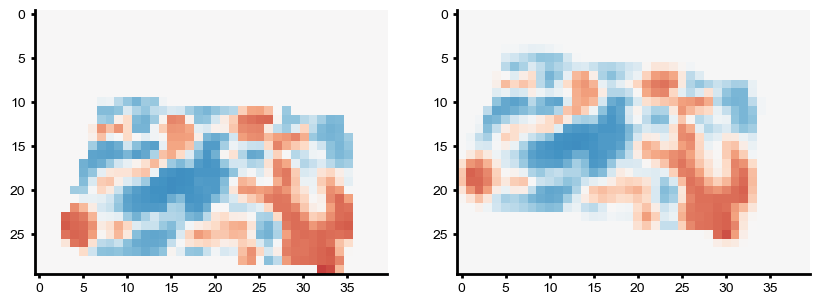

In [80]:
t=100
fig, axs = plt.subplots(1,2,figsize=(10,5))
ax = axs[0]
crange = np.max(np.abs(model_data['model_vid_sm']))
ax.imshow(model_data['model_vid_sm'][t],vmin=-crange,vmax=crange,cmap='RdBu_r')
ax = axs[1]
ax.imshow(model_vid_sm_shift[t],vmin=-crange,vmax=crange,cmap='RdBu_r')
